# Final assignment

The final exercise involves converting data from one or more providers.

Since this exercise is designed to prepare you for real project work, the information you need to solve it might be slightly incomplete or not provided in context. Use your best judgment!

Parts of this assignment can be solved in several ways. Use descriptive variable names and comments or descriptive text if necessary to clarify.
The final solution should be clear to your colleagues and will be shared with some of your fellow students for review.

The data will be used for MIKE modelling and must be converted to Dfs with **apppropriate EUM types/units** in order to be used by the MIKE software.

The data is provided as a [zip file](https://github.com/DHI/getting-started-with-mikeio/raw/main/mini_book/data/stream_data.zip) and a [NetCDF file](https://github.com/DHI/getting-started-with-mikeio/raw/main/mini_book/data/ERA5_DutchCoast.nc)  (in the data folder - see FA.3 below).

Inside the zip file, there are a many timeseries (ASCII format) of discharge data from streams located across several regions (`*.dat`).

Static data for each region is found in a separate file (`region_info.csv`)

![](../images/region_info.png)

Pandas `read_csv` is very powerful, but here are a few things to keep in mind

* Column separator e.g. comma (,)
* Blank lines
* Comments
* Missing values
* Date format

The MIKE engine can not handle missing values / delete values, **fill in missing values** with interpolated values.

In order to save diskspace, **crop the timeseries** to simulation period Feb 1 - June 30.

## FA.1 Convert all timeseries to Dfs0

In [2]:
import os
import numpy as np
import pandas as pd
import mikeio

from mikeio import Dataset
from mikeio.eum import EUMType, ItemInfo, EUMUnit

In [3]:
# This is one way to find and filter filenames in a directory
# [x for x in os.listdir("datafolder") if "some_str" in x]

In [4]:
# This is useful!
# help(pd.read_csv)

In [5]:
# example of reading csv
# df = pd.read_csv("../data/oceandata.csv", comment='#', index_col=0, sep=',', parse_dates=True)

a) Convert all timeseries to dfs0 (remember that the notebook should be runnable for your peers so put the files somewhere reasonable). 

b) Read s15_east_novayork_river.dfs0, print the "header", plot, and show that the number of missing values is 0.

In [74]:
# a)
path_in = r".\stream_data"
timeseries = [x for x in os.listdir(path_in) if x.endswith(".dat")]

In [75]:
for timeserie in timeseries:
    df = pd.read_csv(os.path.join(path_in, timeserie), comment='%', index_col=0, sep='\t', parse_dates=True)
    ds = mikeio.from_pandas(df)
    # os.makedirs(r'.\results')
    # ds.to_dfs(rf'.\results\{timeserie[0:3]}.dfs0')

In [76]:
# b) 
s15 = mikeio.read(r'.\results\s15.dfs0')
df_15 = s15.to_dataframe()
df_15.head()

,discharge
2005-01-01 12:00:00,0.68
2005-01-02 12:00:00,-99.00
2005-01-03 12:00:00,0.78
2005-01-04 12:00:00,-99.00
2005-01-05 12:00:00,1.27


<Axes: >

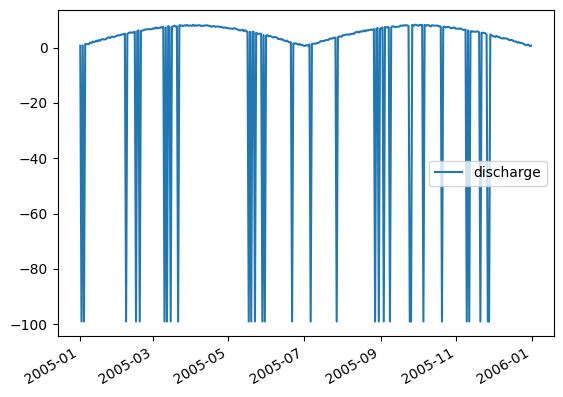

In [77]:
df_15.plot()  

In [78]:
df_15.isnull().sum()

discharge    0
dtype: int64

## FA.2 Add region specific info to normalize timeseries with surface area

Each timeseries belongs to a region identified in the filename, e.g. `s15_east_novayork_river.dat` is located in the `novayork` region.

a) Convert all timeseries to dfs0 with specific discharge, by doing: 

For each timeseries in the dataset:
* Find out which region it belongs to (hint: the string method [split()](https://docs.python.org/3/library/stdtypes.html#str.split) will be useful)
* Divide the timeseries values with the surface area for the region (take into account units)
* Create a dfs0 file with specific discharge *(discharge / area)* (like the one with discharge from FA.1)

b) Determine which station has the largest max specific discharge (in the simulation period).  

In [109]:
# a)
# find out unit of discharge:
EUMType.search('discharge')     # find the EUM Type that matches the discharge
ItemInfo(EUMType.Discharge)     # find the discharge corresponding EUM unit
ds.items[0] = mikeio.ItemInfo(
    name=mikeio.EUMType.Discharge,                  # assign the correct EUM type
    itemtype=mikeio.EUMUnit.meter_pow_3_per_sec)    # assign the coresponding EUM unit

In [112]:
# find out unit of surface_area
region_info = pd.read_csv(r'.\stream_data\region_info.csv', index_col=0)
# unit = km^2
region_info = region_info.sort_values(by='region')
region_info

,surface_area_km2
region,
brockholm,243.570
fothenburg,64.345
hopenfagen,123.200
novayork,783.200
singhai,456.890


In [68]:
split_text = np.char.split(timeseries, sep='_')
locations = []
for x in split_text:
    location = x[2]
    locations.append(location)
unique_locations = np.unique(locations)
unique_locations.sort()
print(unique_locations)

['brockholm' 'fothenburg' 'hopenfagen' 'novayork' 'singhai']


## FA.3 Gridded data

ERA5 wave model for a part of the North Sea is available in the file `"../data/ERA5_DutchCoast.nc"`

The dataset is provided in NetCDF

These are the variables of interest:

* Significant wave height (*Significant height of combined wind waves and swell*)
* Mean wave direction

Info about spatial and temporal axes can be found in the NetCDF file

In [ ]:
import xarray as xr
import mikeio
import numpy as np

ds = xr.open_dataset("../data/ERA5_DutchCoast.nc")

ds

In [ ]:
lons = ds.longitude
lats_rev = ds.latitude[::-1] # reversed

# geometry = mikeio.Grid2D(x=...,y=..., projection="LONG/LAT")
#hm0 = mikeio.DataArray(np.flip(...,axis=1),geometry=geometry, time=ds.time, item=mikeio.ItemInfo(...)))

In [ ]:
# mds = mikeio.Dataset([...])

a) Find the relevant variables in the NetCDF file.

b) Create MIKE IO DataArrays for each variable

c) Combine the arrays into a MIKE IO Dataset and write it to a dfs2 file 

d) Read the data from the file and document that the temporal max at (50N, 1E) of the significant wave height is the same in the dfs2 file as in the NetCDF file (note: due to rounding errors the may not be exactly the same)

The file should look like this in MIKE Zero:
![](../images/waves.png)



## Submission of solution

Your solution to the above tasks is to be delivered in the format of a single Jupyter notebook file. Please create a new and name it final_assignment_xyz.ipynb where xyz is your initials. It should be easy to understand and runnable by your peers.

The solution will be reviewed by some of your fellow students as well as an instructor, which will provide feedback on both the correctnes and clarity of your solution.

The submission and review process is handled by Academy + Eduflow.

